# Future Selection Notebook

# Feature Selection

This notebook focuses on selecting the most relevant features influencing hotel booking cancellation.
The dataset used is the output of the feature engineering stage.
Multiple feature selection techniques are applied to ensure robustness and interpretability.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path


In [20]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [ ]:
data_path = Path("../processed data/hotel_bookings_final.pkl")
df = pd.read_pickle(data_path)
print(df.head())
print(df.shape)

   is_canceled  lead_time  arrival_date_year  arrival_date_month  \
0            0   2.869220          -1.764073           -0.085018   
1            0   2.869220          -1.764073           -0.085018   
2            0  -0.872600          -1.764073           -0.085018   
3            0  -0.799707          -1.764073           -0.085018   
4            0  -0.787558          -1.764073           -0.085018   

   arrival_date_week_number  arrival_date_day_of_month  \
0                  0.011865                  -1.676896   
1                  0.011865                  -1.676896   
2                  0.011865                  -1.676896   
3                  0.011865                  -1.676896   
4                  0.011865                  -1.676896   

   stays_in_weekend_nights  stays_in_week_nights    adults  children  ...  \
0                -0.974216             -1.287092  0.245683 -0.304662  ...   
1                -0.974216             -1.287092  0.245683 -0.304662  ...   
2          

In [22]:
df.shape

(87389, 70)

In [24]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [25]:
X_num = X.select_dtypes(include=["int64", "float64"])
X_num.shape


(87389, 26)

In [26]:
X.shape, y.shape


((87389, 69), (87389,))

## Correlation Analysis Insights

Correlation analysis provides an initial statistical understanding of the
relationship between numerical features and booking cancellation.

Features such as lead time, number of previous cancellations, and deposit-related
variables show stronger correlation with cancellation behavior.
This step helps narrow down potentially important features before applying
more advanced selection techniques.


In [27]:
corr = X_num.corrwith(y).sort_values(ascending=False)


In [28]:
corr.head(10)


lead_time               0.187953
lead_to_stay_ratio      0.155323
adr                     0.134782
has_agent_flag          0.132719
total_guests            0.104613
adr_per_person          0.093361
adults                  0.090560
arrival_date_year       0.088021
total_stay_nights       0.084643
stays_in_week_nights    0.083610
dtype: float64

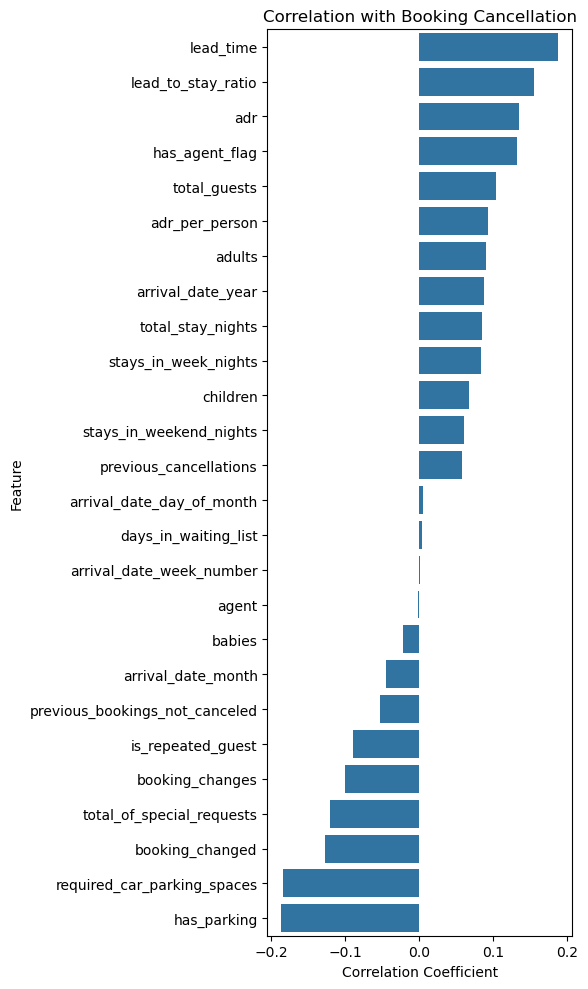

In [29]:
plt.figure(figsize=(6,10))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation with Booking Cancellation")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## ANOVA Filter Method

The ANOVA F-test is a filter-based feature selection technique that evaluates
the statistical significance of each numerical feature with respect to the
target variable (`is_canceled`).

Features with higher F-scores indicate stronger discriminatory power between
canceled and non-canceled bookings.


In [30]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_num, y)

anova_features = X_num.columns[selector.get_support()]
anova_features


Index(['lead_time', 'booking_changes', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_guests', 'lead_to_stay_ratio',
       'booking_changed', 'has_parking', 'has_agent_flag'],
      dtype='object')

## Lasso-Based Feature Selection

Lasso-based feature selection is implemented using Logistic Regression with
L1 regularization.

This approach automatically eliminates less important features by shrinking
their coefficients to zero, resulting in a more compact and interpretable
feature set suitable for classification tasks.


In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000
)

lasso_model.fit(X_scaled, y)

lasso_features = X_num.columns[lasso_model.coef_[0] != 0]
lasso_features


Index(['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_stay_nights', 'total_guests',
       'lead_to_stay_ratio', 'booking_changed', 'has_parking',
       'adr_per_person', 'has_agent_flag'],
      dtype='object')

## Recursive Feature Elimination (RFE)

Recursive Feature Elimination (RFE) is a wrapper-based method that iteratively
removes the least important features based on model performance.

By repeatedly fitting a Logistic Regression model, RFE identifies a subset of
features that contribute most to predicting booking cancellation.


In [32]:
model = LogisticRegression(max_iter=1000, solver='liblinear')

rfe = RFE(model, n_features_to_select=12)
rfe.fit(X_scaled, y)

rfe_features = X_num.columns[rfe.support_]
rfe_features


Index(['lead_time', 'arrival_date_year', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_guests', 'booking_changed', 'has_parking', 'adr_per_person',
       'has_agent_flag'],
      dtype='object')

## Final Selected Feature Set

The final feature set is determined by selecting features that consistently
appear across multiple feature selection techniques, including ANOVA,
Lasso-based selection, and RFE.

This consensus-based approach improves robustness and reduces selection bias.


In [33]:
final_features = list(
    set(anova_features)
    & set(lasso_features)
    & set(rfe_features)
)

final_features


['has_parking',
 'total_of_special_requests',
 'required_car_parking_spaces',
 'total_guests',
 'booking_changed',
 'has_agent_flag',
 'lead_time']

In [ ]:
output_dir = Path("../processed data")
output_dir.mkdir(parents=True, exist_ok=True)

df_selected = df[['is_canceled'] + final_features]
df_selected.to_pickle(output_dir / "hotel_bookings_selected.pkl")

with open(output_dir / "final_selected_features.pkl", 'wb') as f:
    pickle.dump(final_features, f)


## Feature Importance Interpretation

Feature importance is derived from the coefficients of a Logistic Regression model.

Positive coefficient values indicate features that increase the likelihood of
booking cancellation, while negative coefficients are associated with reduced
cancellation probability.

Lead time and deposit-related features emerge as key drivers influencing
customer cancellation behavior.


In [40]:
log_model = LogisticRegression(max_iter=1000, solver='liblinear')
log_model.fit(X_num[final_features], y)

importance = pd.Series(
    log_model.coef_[0],
    index=final_features
).sort_values()


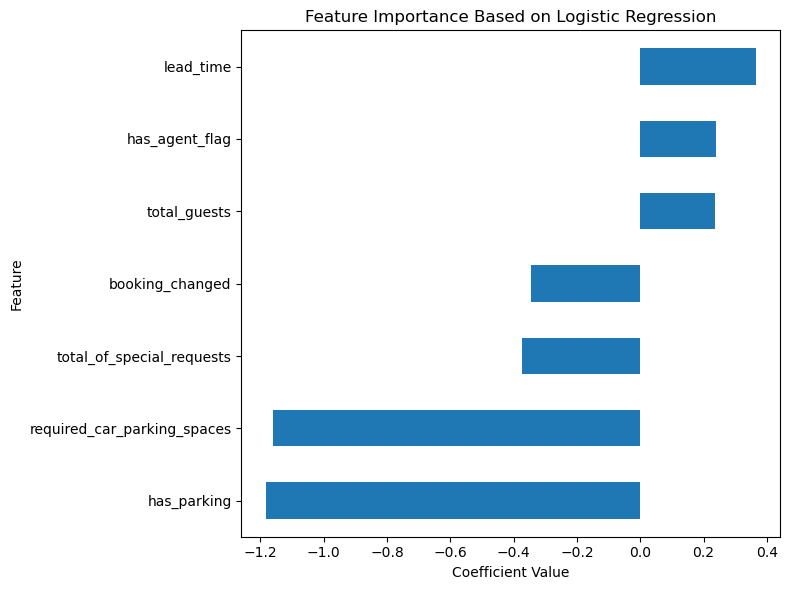

In [41]:
plt.figure(figsize=(8,6))
importance.plot(kind='barh')
plt.title("Feature Importance Based on Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Feature Selection Summary

This notebook applied multiple feature selection techniques, including:

- Correlation analysis
- ANOVA F-test (filter method)
- Lasso-based selection using L1-regularized Logistic Regression
- Recursive Feature Elimination (RFE)

The resulting selected dataset is optimized for downstream tasks such as:
- Predictive modeling
- Hypothesis testing
- Dimensionality reduction (PCA)
- Customer behavior analysis
